# Data Cleaning

## Retrieving reviews

In [68]:
import os
import pandas as pd
import nltk
import numpy as np
import pandas as pd
import regex
import string
import unicodedata
import html
from html.parser import HTMLParser
import matplotlib.pyplot as plt

from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchtext import data
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

In [8]:
hotel_reviews=pd.DataFrame()
for stance in os.listdir('./op_spam_v1.4'):
    negative_path=os.listdir('./op_spam_v1.4/'+stance)
    for val in negative_path:
        for i in range(1,6):
            next_path='./op_spam_v1.4/'+stance+'/'+val+'/'+'fold'+str(i)
            file_names=os.listdir(next_path)
            content=[]
            hotel_name=[]
            for name in file_names:
                full_path=next_path+'/'+name
                next_name=name.split('_')[1]
                hotel_name.append(next_name)
                with open (full_path,'r') as myfile:
                    content.append(myfile.read())
            file_amount=len(file_names)
            val_label=file_amount*[val.split('_')[0]]
            stance_label=file_amount*[stance.split('_')[0]]
            resource=[val.split('_')[2]]*file_amount
            next_dict={'Resource':resource,'Hotel':hotel_name,'Review':content,'Stance':stance_label,'Authenticity':val_label}
            next_df=pd.DataFrame(next_dict)
            hotel_reviews=pd.concat([hotel_reviews,next_df],axis=0)
    
                        

In [9]:
hotel_reviews.head()

,Resource,Hotel,Review,Stance,Authenticity
0,MTurk,hilton,We stayed at the Schicago Hilton for 4 days an...,negative,deceptive
1,MTurk,hilton,Hotel is located 1/2 mile from the train stati...,negative,deceptive
2,MTurk,hilton,I made my reservation at the Hilton Chicago be...,negative,deceptive
3,MTurk,hilton,"When most people think Hilton, they think luxu...",negative,deceptive
4,MTurk,hilton,My husband and I recently stayed stayed at the...,negative,deceptive


Now we have the row dataframe that we wanted, with those attributes(hotel name, sentiment polarity, resource, review and a label(authenticity))! We can move the next step which is cleaning and tokenizing data.

## Cleaning and Tokenizing

We need to build a preprocessor first tokenize the reviews.

In [7]:
class Preprocessor(BaseEstimator, TransformerMixin):


    def __init__(self, lower=True, strip=True, remove_punct=True, remove_diacritics=True, unicode_form='NFC', remove_stop=False, stem_tokens=False, lemmatize_tokens=True, language='english'):
        
        self.lower      = lower
        self.strip      = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
     
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    

        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct      = set(string.punctuation)

        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

 
    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]


    def fit(self, X, y=None):
        return self

 
    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))


    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)


    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'


    def show_settings(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)


    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False


    # normalize token strings
    def normalize_string(self, token):

        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

Now we will use the preprocessor to tokenize the reviews

In [17]:
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=True, lemmatize_tokens=True)
hotel_reviews['Review']=hotel_reviews['Review'].apply(my_preprocessor.tokenize)
hotel_reviews.head()

,Resource,Hotel,Review,Stance,Authenticity
0,MTurk,hilton,"[stay, schicago, hilton, 4, day, 3, night, con...",negative,deceptive
1,MTurk,hilton,"[hotel, locate, 1/2, mile, train, station, qui...",negative,deceptive
2,MTurk,hilton,"[make, reservation, hilton, chicago, believe, ...",negative,deceptive
3,MTurk,hilton,"[people, think, hilton, think, luxury, know, w...",negative,deceptive
4,MTurk,hilton,"[husband, recently, stay, stay, hilton, chicag...",negative,deceptive


Let's check the data type of the columns in this dataframe

In [18]:
hotel_reviews.dtypes

Resource        object
Hotel           object
Review          object
Stance          object
Authenticity    object
dtype: object

We need to change our label to category type

In [19]:
hotel_reviews['Authenticity']=hotel_reviews['Authenticity'].astype('category')

Before we split the dataframe into train and test data, I will save it to a csv file firstly.

In [22]:
hotel_reviews.to_csv('Hotel_reviews.csv',header=True,index=False)

## Prepare training and test data

In [55]:
hotel_reviews = pd.read_csv('Hotel_reviews.csv')

In [56]:
hotel_reviews.head()

,Resource,Hotel,Review,Stance,Authenticity
0,MTurk,hilton,"['stay', 'schicago', 'hilton', '4', 'day', '3'...",negative,deceptive
1,MTurk,hilton,"['hotel', 'locate', '1/2', 'mile', 'train', 's...",negative,deceptive
2,MTurk,hilton,"['make', 'reservation', 'hilton', 'chicago', '...",negative,deceptive
3,MTurk,hilton,"['people', 'think', 'hilton', 'think', 'luxury...",negative,deceptive
4,MTurk,hilton,"['husband', 'recently', 'stay', 'stay', 'hilto...",negative,deceptive


In [57]:
hotel_reviews['Review'] = hotel_reviews['Review'].apply(lambda x: ' '.join(eval(x)))

In [165]:
texts=hotel_reviews['Review']
labels=hotel_reviews['Authenticity']


# Logistic Regression

In [166]:
train_texts, test_texts, train_labels, test_labels \
    = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [167]:
tfidf_vectorizer = TfidfVectorizer()

In [168]:
train_tfidf_sparse_matrix = tfidf_vectorizer.fit_transform(train_texts)
test_tfidf_sparse_matrix = tfidf_vectorizer.transform(test_texts)

In [169]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(train_tfidf_sparse_matrix, train_labels)

In [170]:
pred_test_labels = clf.predict(test_tfidf_sparse_matrix)

In [171]:
print("Accuracy:", accuracy_score(test_labels, pred_test_labels))
print("Precision:", precision_score(test_labels, pred_test_labels, average="macro"))
print("Recall:", recall_score(test_labels, pred_test_labels, average="macro"))
print("Macro F1:", f1_score(test_labels, pred_test_labels, average="macro"))

Accuracy: 0.865625
Precision: 0.8671131128758247
Recall: 0.8638784461152882
Macro F1: 0.8647998034880864


In [172]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [173]:
from sklearn.metrics import plot_confusion_matrix

In [174]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

In [175]:
cnf_matrix = confusion_matrix(test_labels, pred_test_labels, labels=['deceptive', 'truthful'])

Confusion matrix, without normalization
[[151  17]
 [ 26 126]]


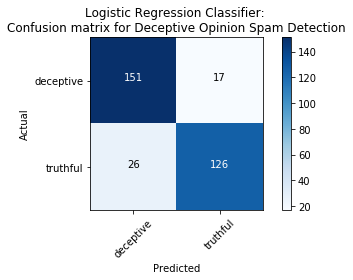

In [176]:

plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['deceptive', 'truthful'], 
                      title='Logistic Regression Classifier: \nConfusion matrix for Deceptive Opinion Spam Detection')

In [181]:
test_labels_int = list(map(lambda x: label_to_index[x], test_labels.tolist()))
pred_test_labels_int = list(map(lambda x: label_to_index[x], pred_test_labels))

In [182]:
from sklearn.metrics import classification_report as clsr
print(clsr(test_labels_int, pred_test_labels_int, target_names=['deceptive', 'truthful']))

              precision    recall  f1-score   support

   deceptive       0.85      0.90      0.88       168
    truthful       0.88      0.83      0.85       152

    accuracy                           0.87       320
   macro avg       0.87      0.86      0.86       320
weighted avg       0.87      0.87      0.87       320



We used another supervised learning model logistic regression to classify authenticity. For logistic regression model, we take the processed textual data and transform to TF-IDF vectors as the input data. The model achieved an accuracy of 86.6%, precision of 86.7%, recall of 86.4%, and f1 score of 86.4%. 

# Bert

In [112]:
texts=hotel_reviews['Review']
labels=hotel_reviews['Authenticity']

In [113]:
label_to_index = {}
index_to_label = {}
label_lst = list(set(labels))
for i in range(len(label_lst)):
    label = label_lst[i]
    label_to_index[label] = i
    index_to_label[i] = label

In [116]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [117]:
input_ids = []
for text in texts:
    encoded_sent = tokenizer.encode(text,
                                    add_special_tokens=True, 
                                    max_length=128,
                                    truncation=True)
    input_ids.append(encoded_sent)

In [118]:
print('Max sentence length: ', max([len(sent) for sent in input_ids]))

Max sentence length:  128


In [119]:
input_ids = pad_sequences(input_ids, maxlen=128, dtype="long", 
                          value=0, truncating="post", padding="post")

In [120]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [121]:
labels = [label_to_index[label] for label in labels]

In [122]:
train_input_ids, test_input_ids, train_labels, test_labels \
    = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

train_attention_masks, test_attention_masks, train_labels, test_labels \
    = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)

In [123]:
train_input_ids = torch.tensor(train_input_ids)
test_input_ids = torch.tensor(test_input_ids)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

train_attention_masks = torch.tensor(train_attention_masks)
test_attention_masks = torch.tensor(test_attention_masks)

In [124]:
batch_size = 32
# Create the DataLoader for our training set.
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [149]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = len(label_lst),  
    output_attentions = False, 
    output_hidden_states = False
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [150]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(6))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
We will use the GPU: Quadro RTX 8000


In [151]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

In [152]:
for epoch_i in range(10):
    print("")
    print('Epoch {}'.format(epoch_i + 1))
    print('Training...')
    
    total_loss = 0
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))


Epoch 1
Training...
Average training loss: 0.62

Epoch 2
Training...
Average training loss: 0.42

Epoch 3
Training...
Average training loss: 0.29

Epoch 4
Training...
Average training loss: 0.15

Epoch 5
Training...
Average training loss: 0.08

Epoch 6
Training...
Average training loss: 0.06

Epoch 7
Training...
Average training loss: 0.07

Epoch 8
Training...
Average training loss: 0.02

Epoch 9
Training...
Average training loss: 0.01

Epoch 10
Training...
Average training loss: 0.01


In [153]:
model.eval()
preds_test = []
labels_test = []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    preds_test += list(preds_flat)
    labels_test += list(labels_flat)

In [154]:
print("Accuracy:", accuracy_score(labels_test, preds_test))
print("Precision:", precision_score(labels_test, preds_test, average="macro"))
print("Recall:", recall_score(labels_test, preds_test, average="macro"))
print("Macro F1:", f1_score(labels_test, preds_test, average="macro"))

Accuracy: 0.846875
Precision: 0.849616439445129
Recall: 0.8444548872180451
Macro F1: 0.8456069870715546


In [155]:
labels_test_txt = list(map(lambda x: index_to_label[x], labels_test))
preds_test_txt = list(map(lambda x: index_to_label[x], preds_test))
cnf_matrix = confusion_matrix(labels_test_txt, preds_test_txt, labels=['deceptive', 'truthful'])

Confusion matrix, without normalization
[[150  18]
 [ 31 121]]


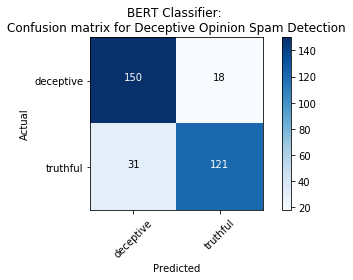

In [156]:

plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['deceptive', 'truthful'], 
                      title='BERT Classifier: \nConfusion matrix for Deceptive Opinion Spam Detection')

In [183]:
print(clsr(labels_test, preds_test, target_names=['deceptive', 'truthful']))

              precision    recall  f1-score   support

   deceptive       0.83      0.89      0.86       168
    truthful       0.87      0.80      0.83       152

    accuracy                           0.85       320
   macro avg       0.85      0.84      0.85       320
weighted avg       0.85      0.85      0.85       320



We also used BERT which is a transformer-based machine learning model for our classification problem. For BERT model, it is different from logistic regression. We pass in the textual data and BERT will tokenize the texts by inserting some tokens to indicate the start and end of the sentence. BERT will also use mask to separate different sentences. Each token will be mapped to a token id. Position embeddings are also added to indicate the position of each token. After tokenizing the input, the token ids as well as the attention masks will be fed into classifier.

## Conclusion

Based on the evaluation on the test set, we can observe that BERT model is slightly better than logistic regression and Naive Bayes, but not as good as SVM. This could be because that the dataset is not a complex task. For more complex tasks, BERT model can be expected to perform better. But overall, all the models we trained made pretty accurate predictions on this dataset.

In the future, we could improve by incorporating word2vec embeddings instead of using TF-IDF and
count vectorizers, or include more feature engineering techniques before modeling.